In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels 
import pywt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

## Interpreting Partial Autocorrelation

https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c


https://datascience.stackexchange.com/questions/39065/how-is-pacf-analysis-output-related-to-lstm

When used for time series, LSTM (or any Neural Network approach) fall under the category of auto-regressive models. The most general formulation of an auto-regressive model is:

Yt=f(Yt−1,Yt−2,...,Yt−n) with n the number of past lags to include in your model.

When using a neural network for univariate time series modeling, n will determine the number of input neurons to use (It could be n, or could be n+k, with k additional causal features).

The PACF will help you determine n.

The key here is that neural networks are a generalization of AR(p) models.

<img src = "Financial_Forecasting_Model.PNG" width="500" height="500">

## Removing (high-frequency) noise using the DWT

In [2]:
df = pd.read_parquet('../data/Tensor_Portfolio.parquet')

In [3]:
df['Ticker'].unique()

array(['ADAUSDT', 'BNBBTC', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'IOTAUSDT', 'LTCUSDT', 'MKRUSDT', 'TRXUSDT',
       'XLMUSDT', 'XMRBTC'], dtype=object)

In [81]:
ticker = 'XMRBTC'

In [82]:
prices_return = df[df['Ticker'] == ticker].copy()
prices_return = prices_return['Close_target_return_15m'].values

In [83]:
prices_return

array([ 0.00434052, -0.00446117,  0.00028007, ..., -0.00301016,
       -0.00163543,  0.00189012])

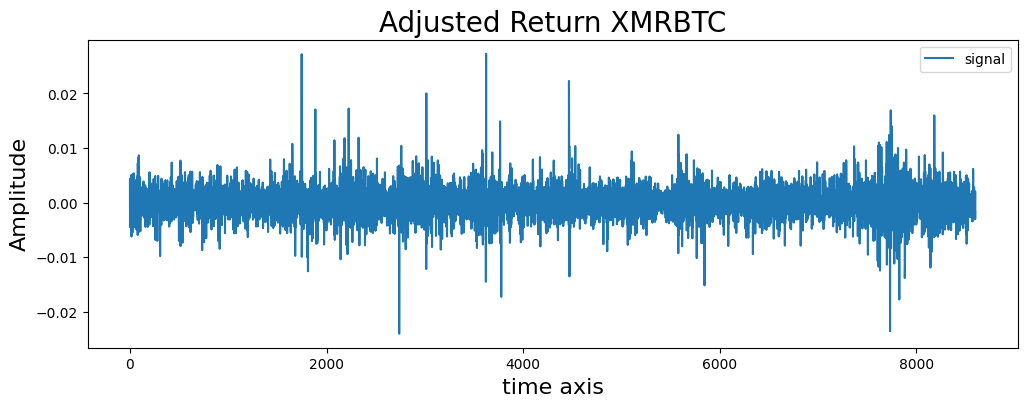

In [84]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(prices_return, label='signal')
ax.legend(loc='upper right')
ax.set_title(f'Adjusted Return {ticker}', fontsize=20)
ax.set_xlabel('time axis', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
plt.show()

In [85]:

# Threshold for Wavelet Denoising (from 0.0 to 1.0)
thresh = 0.1 

# Wavelet Transformation Function
wavelet = "sym4"

# Candle Stick Upsample Range (in minutes)
minute_sampling = 15

# lookback subset to PACF pattern search
pacf_days_subset = 15

# Number of hours to consider for 
# lag pattern lookup
nn_hours_pattern_lookup = 12

# Length of Subset Timeseries
subset_wavelet_transform = int(24*(60/minute_sampling)*pacf_days_subset) #60*hours # Number 

# Number of lags to analyse in Partial Autocorrelation Function
# 48 lags * 15 min_sampling / 60 hours per minute = 12 Hours in lags
lags_pacf = (60/minute_sampling)*nn_hours_pattern_lookup  

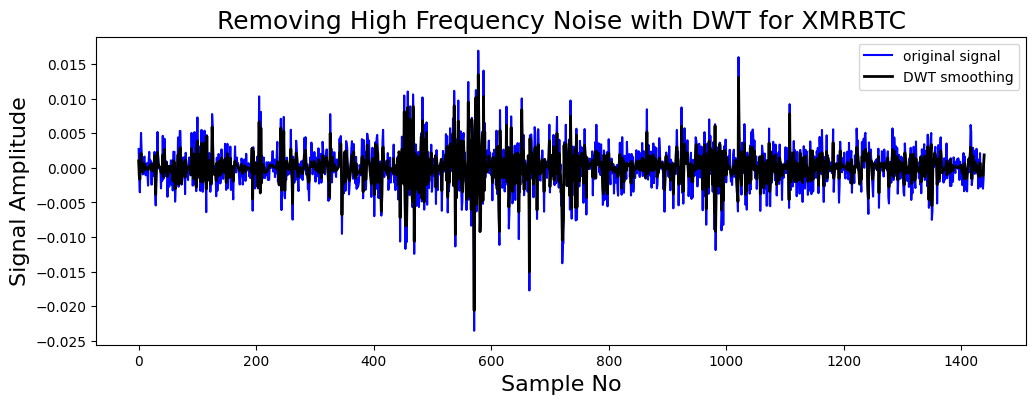

In [86]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db5"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal


fig, ax = plt.subplots(figsize=(12,4))
ax.plot(prices_return[-subset_wavelet_transform:], color="b", alpha=0.99, label='original signal')
rec = lowpassfilter(prices_return[-subset_wavelet_transform:], thresh, wavelet)
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title(f'Removing High Frequency Noise with DWT for {ticker}', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()



## Analysing Partial Autocorrelation

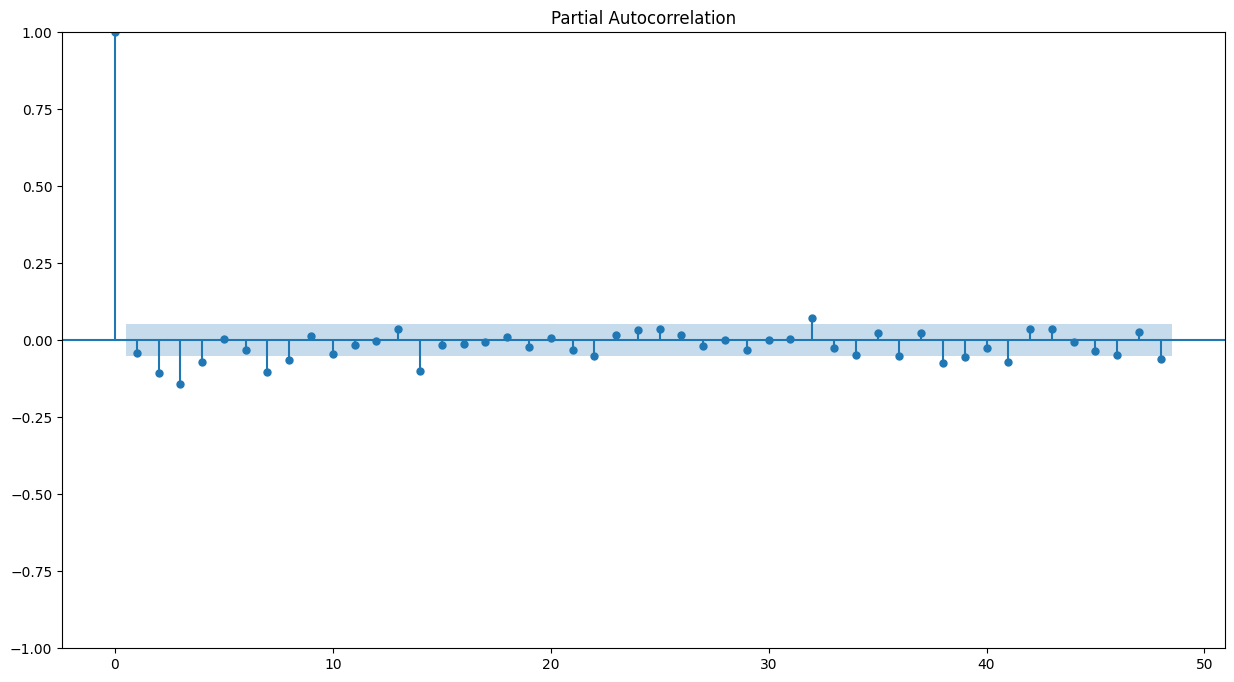

In [87]:
plt.rcParams["figure.figsize"] = (15,8)
plot_pacf(rec, lags = lags_pacf, method = "ols", alpha = 0.05)
plt.show()

In [88]:
pacf_values, confint = pacf(rec, nlags = lags_pacf, alpha = .05, method = "ols")

In [89]:
def get_significant_max_lag_pacf(pacf_values : np.ndarray, 
                                confint: np.ndarray ) -> int:

    # From https://github.com/statsmodels/statsmodels/blob/8962c7fceb458d1237d977d5da605b814f4230a0/statsmodels/graphics/tsaplots.py#L31
    lower_limit, upper_limit = confint[:, 0] - pacf_values, confint[:, 1] - pacf_values

    # Get latest lag Position where PACF is significant
    # First get all significant position values, greater than upper limit 
    # or lower than lower limit. 
    # Then reverse list and get first position of True Element
    pacf_upper = list(pacf_values > upper_limit)
    pacf_lower = list(pacf_values < lower_limit)

    pacf_upper.reverse()
    pacf_lower.reverse()

    # Try to find a significant pacf value
    # if there isn't one, then assign lags_pacf
    # as the most relevant lag position, 
    # this will make max_lag_pacf = 0, 
    # meaning there isn't any relevant correlation
    # among the given lags
    try:
        pacf_upper_position = pacf_upper.index(True)
    except:
        pacf_upper_position = lags_pacf

    try:
        pacf_lower_position = pacf_lower.index(True)
    except:
        pacf_lower_position = lags_pacf


    return lags_pacf - min(pacf_upper_position, pacf_lower_position)

In [90]:
max_lag_pacf = get_significant_max_lag_pacf(pacf_values,
                                confint )

In [91]:
print("For Ticker ",ticker , " the max significant autocorrelation is ", max_lag_pacf , " lag.")

For Ticker  XMRBTC  the max significant autocorrelation is  48.0  lag.


## Discrete Wavelet Transform Analysis

In [150]:
def plot_frequency_subbands(signal, wavelet_coeff):

    n_plots = len(wavelet_coeff) +1 

    fig, axarr = plt.subplots(nrows=n_plots , ncols=1, figsize=(10,15))

    ii = 0
    axarr[ii].set_title("Original Signal", fontsize=8)
    axarr[ii].set_ylabel("Original Signal", fontsize=8, rotation=90)
    axarr[ii].plot(signal, 'b')
    axarr[ii].set_yticklabels([])

    for ii in range(1 , n_plots ):
        if ii == 1:
            axarr[ii].set_title("Frequency Subbands", fontsize=8)
            axarr[ii].set_ylabel("Aprox. {}".format(ii), fontsize=8, rotation=90)
            axarr[ii].plot(wavelet_coeff[ii -1], 'r')
            axarr[ii].set_yticklabels([])
        else:
            axarr[ii].set_ylabel("Detail {}".format(ii -1), fontsize=8, rotation=90)
            axarr[ii].plot(wavelet_coeff[ii -1], 'g')
            axarr[ii].set_yticklabels([])
        
    plt.tight_layout()
    plt.show()


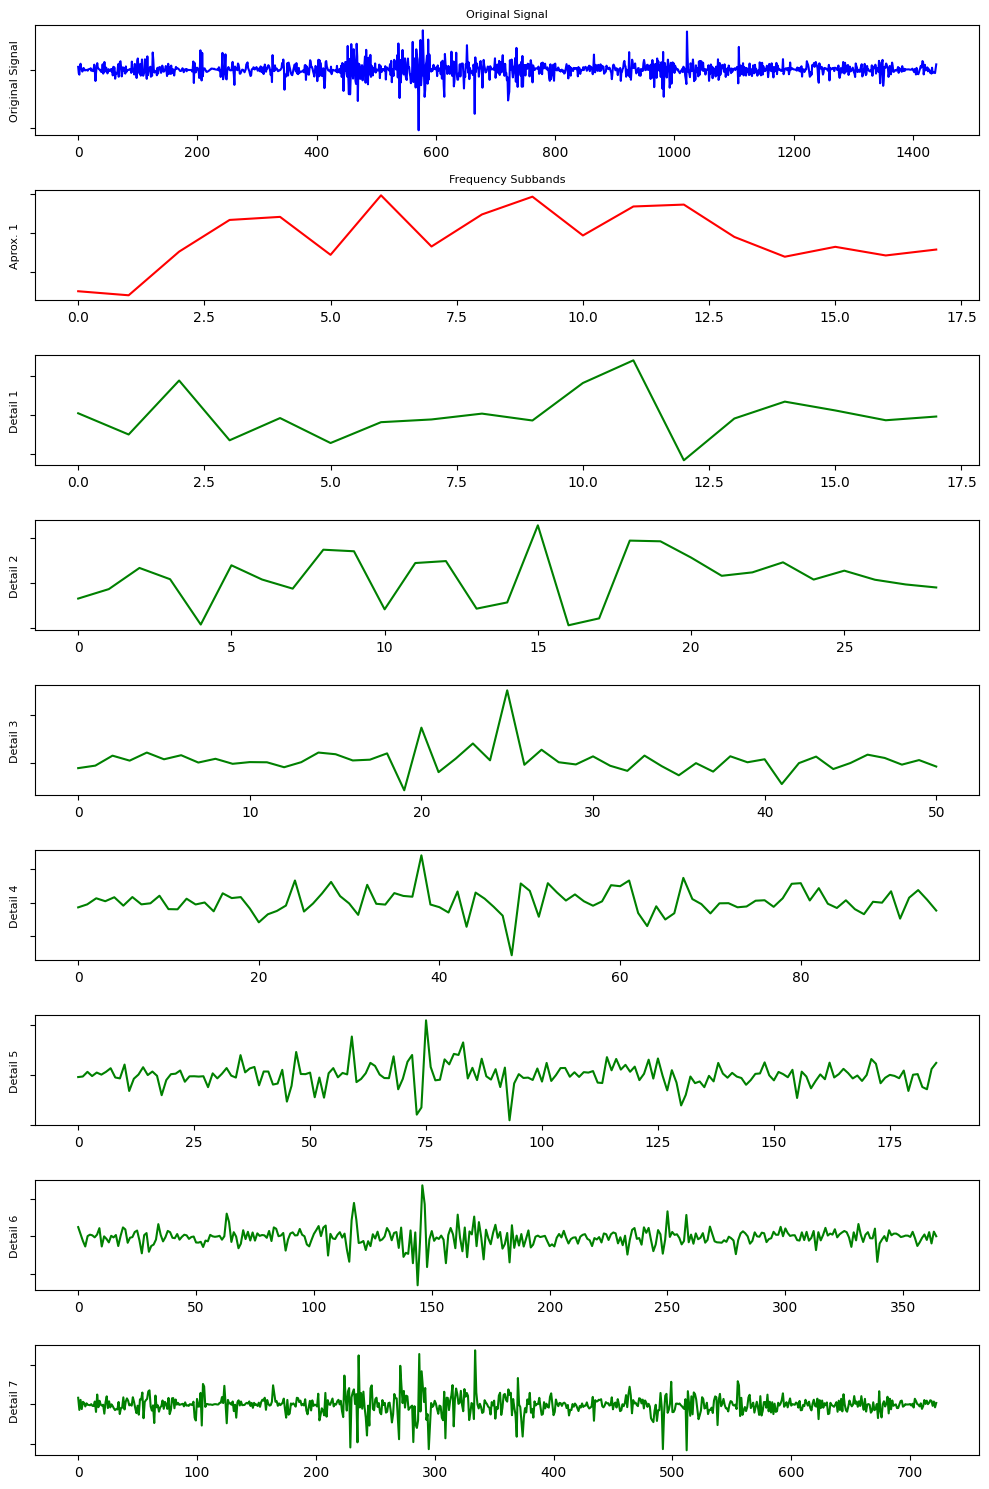

In [151]:
ts = rec
#wavelet = 'rbio3.1' #'db2'
coeff = pywt.wavedec(ts, wavelet)


plot_frequency_subbands(signal = ts, 
                        wavelet_coeff = coeff)
